## Set-Up VGGT

In [1]:
!git clone https://github.com/facebookresearch/vggt.git vggt-f/
!mkdir exports
!mv vggt-f/* .
!rm -r vggt-f
!pip install -r requirements.txt

Cloning into 'vggt-f'...
remote: Enumerating objects: 1265, done.
remote: Total 1265 (delta 0), reused 0 (delta 0), pack-reused 1265 (from 1)
Receiving objects: 100% (1265/1265), 64.94 MiB | 29.90 MiB/s, done.
Resolving deltas: 100% (579/579), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.9/17.9 MB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from PIL import Image
from sklearn.cluster import KMeans
import numpy as np
import os
from tqdm import tqdm
from sklearn.metrics import pairwise_distances
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from vggt.models.vggt import VGGT
from vggt.utils.load_fn import load_and_preprocess_images
from vggt.utils.pose_enc import pose_encoding_to_extri_intri

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# bfloat16 is supported on Ampere GPUs (Compute Capability 8.0+)
dtype = torch.bfloat16 if torch.cuda.get_device_capability()[0] >= 8 else torch.float16

# Initialize the model and load the pretrained weights.
# This will automatically download the model weights the first time it's run, which may take a while.
model = VGGT()
_URL = "https://huggingface.co/facebook/VGGT-1B/resolve/main/model.pt"
model.load_state_dict(torch.hub.load_state_dict_from_url(_URL))
model = model.to(device)


Downloading: "https://huggingface.co/facebook/VGGT-1B/resolve/main/model.pt" to /root/.cache/torch/hub/checkpoints/model.pt
100%|██████████| 4.68G/4.68G [01:15<00:00, 66.8MB/s]


## Dataset

In [4]:
#  get dataset
! wget -P /content/Downloads https://www.eth3d.net/data/slam/datasets/einstein_1_mono.zip
# !wget -P /content/Downloads https://www.eth3d.net/data/bridge_dslr_jpg.7z

--2025-11-24 18:20:21--  https://www.eth3d.net/data/slam/datasets/einstein_1_mono.zip
Resolving www.eth3d.net (www.eth3d.net)... 129.132.89.155
Connecting to www.eth3d.net (www.eth3d.net)|129.132.89.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178381436 (170M) [application/zip]
Saving to: ‘/content/Downloads/einstein_1_mono.zip’

einstein_1_mono.zip 100%[===================>] 170.12M  23.6MB/s    in 8.0s    

2025-11-24 18:20:30 (21.4 MB/s) - ‘/content/Downloads/einstein_1_mono.zip’ saved [178381436/178381436]



In [5]:
!unzip /content/Downloads/einstein_1_mono.zip -d /content/Downloads
# !7z x /content/Downloads/bridge_dslr_jpg.7z -o/content/Downloads

Archive:  /content/Downloads/einstein_1_mono.zip
   creating: /content/Downloads/einstein_1/
  inflating: /content/Downloads/einstein_1/calibration.txt  
  inflating: /content/Downloads/einstein_1/groundtruth.txt  
   creating: /content/Downloads/einstein_1/rgb/
  inflating: /content/Downloads/einstein_1/rgb.txt  
 extracting: /content/Downloads/einstein_1/rgb/5387.889786.png  
 extracting: /content/Downloads/einstein_1/rgb/5387.926649.png  
 extracting: /content/Downloads/einstein_1/rgb/5387.963513.png  
 extracting: /content/Downloads/einstein_1/rgb/5388.000376.png  
 extracting: /content/Downloads/einstein_1/rgb/5388.037239.png  
 extracting: /content/Downloads/einstein_1/rgb/5388.074103.png  
 extracting: /content/Downloads/einstein_1/rgb/5388.110966.png  
 extracting: /content/Downloads/einstein_1/rgb/5388.147830.png  
 extracting: /content/Downloads/einstein_1/rgb/5388.184693.png  
 extracting: /content/Downloads/einstein_1/rgb/5388.221557.png  
 extracting: /content/Downloads/ei

In [6]:
DATASET_PATH = "/content/Downloads/einstein_1/"
IMAGES_PATH = DATASET_PATH+"rgb/"
GROUNDTRUTH_PATH = DATASET_PATH+"groundtruth.txt"
# DATASET_PATH = "/content/Downloads/bridge/"
# IMAGES_PATH = DATASET_PATH+"images/dslr_images/"
# POINTS_PATH = DATASET_PATH+"dslr_calibration_jpg/points3D.txt"
# IMAGES_LIST_FILE = DATASET_PATH+'dslr_calibration_jpg/images.txt'

In [7]:
import os

num_imgs = os.listdir(IMAGES_PATH)
print("Number of items:", len(num_imgs))

Number of items: 487


## Set Up DINOv2

In [8]:
# 1. Load Pre-trained DINOv2 (Excellent for geometry/similarity)
print("Loading DINOv2...")
dinov2 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14').cuda()
dinov2.eval()


Loading DINOv2...


Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth
100%|██████████| 84.2M/84.2M [00:00<00:00, 174MB/s]


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (norm): LayerNorm((384,), eps=1e-06, elementwise_affi

In [9]:
transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def get_embedding(img_path):
    img = Image.open(img_path).convert('RGB')
    img_t = transform(img).unsqueeze(0).cuda()
    with torch.no_grad():
        # Extract features (use .flatten for simple vector)
        embedding = dinov2(img_t).cpu().numpy().flatten()
    return embedding


## Processing Dataset

In [10]:
MAX_IMAGE_FILES = 487
SUBSET_SIZE = 10
N = SUBSET_SIZE

In [11]:
# 2. Process Dataset
image_folder = IMAGES_PATH
image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.png'))]
image_files.sort()
image_files = image_files[:MAX_IMAGE_FILES]


In [12]:
uniform_N_samples = np.linspace(0, len(image_files)-1, num=N, dtype=int)
image_files_uniform_N = [image_files[i] for i in uniform_N_samples]

random_N_samples = np.random.choice(len(image_files), size=N, replace=False)
image_files_random_N = [image_files[i] for i in random_N_samples]

In [13]:
uniform_N_samples

array([  0,  54, 108, 162, 216, 270, 324, 378, 432, 486])

In [14]:
random_N_samples

array([349, 471,  12, 117, 168, 403, 345, 118, 247,  72])

In [15]:
# Generate Embeddings

embeddings = []
valid_files = []

print(f"Processing {len(image_files)} images...")
for f in tqdm(image_files):
    try:
        embeddings.append(get_embedding(f))
        valid_files.append(f)
    except Exception as e:
        print(f"Skipping {f}: {e}")

embeddings = np.array(embeddings)


Processing 487 images...


100%|██████████| 487/487 [00:15<00:00, 30.82it/s]


In [16]:

# 3. K-Means Clustering (The Selection Logic)
# If we want a subset of N images, we find N clusters
TARGET_SUBSET_SIZE = N
kmeans = KMeans(n_clusters=TARGET_SUBSET_SIZE, random_state=42)
clusters = kmeans.fit_predict(embeddings)

selected_images_kmeans = []
best_indices_kmeans = []
print("Selecting representative images...")

# For each cluster, find the image closest to the center
for i in range(TARGET_SUBSET_SIZE):
    # Indices of images in this cluster
    indices = np.where(clusters == i)[0]

    # Calculate distance to cluster center
    cluster_center = kmeans.cluster_centers_[i]
    distances = np.linalg.norm(embeddings[indices] - cluster_center, axis=1)

    # Pick the index with min distance
    best_idx = indices[np.argmin(distances)]
    selected_images_kmeans.append(valid_files[best_idx])
    best_indices_kmeans.append(best_idx)

print(f"Selected {len(selected_images_kmeans)} diverse images.")
# Save or copy these images to a 'input_subset' folder for VGGT

Selecting representative images...
Selected 10 diverse images.


In [17]:
best_indices_kmeans.sort()
best_indices_kmeans = np.array(best_indices_kmeans)
best_indices_kmeans, uniform_N_samples, random_N_samples

(array([ 36, 119, 162, 223, 269, 328, 346, 403, 450, 471]),
 array([  0,  54, 108, 162, 216, 270, 324, 378, 432, 486]),
 array([349, 471,  12, 117, 168, 403, 345, 118, 247,  72]))

In [18]:
def farthest_point_sampling(embeddings, k):
    """
    embeddings: shape (N, D) - N images, D dims (e.g. 768 for DINOv2)
    k: target number of images
    """
    num_samples = embeddings.shape[0]
    selected_indices = [np.random.randint(num_samples)] # Start with random

    # Distance cache: maintains min distance from current set to all points
    # Initialize with distance from the first selected point
    min_dists = pairwise_distances(embeddings[selected_indices], embeddings).flatten()

    for _ in range(1, k):
        # The point with the maximum distance to the current set is the most "novel"
        farthest_idx = np.argmax(min_dists)
        selected_indices.append(farthest_idx)

        # Update distances: New dist is min(old_dist, dist_to_new_point)
        new_dists = pairwise_distances(embeddings[farthest_idx:farthest_idx+1], embeddings).flatten()
        min_dists = np.minimum(min_dists, new_dists)

    return selected_indices

best_indices_farthest_point = farthest_point_sampling(embeddings, N)

In [19]:
best_indices_farthest_point.sort()
best_indices_farthest_point = np.array(best_indices_farthest_point)
best_indices_farthest_point, best_indices_kmeans, uniform_N_samples, random_N_samples

(array([ 65, 135, 174, 197, 208, 242, 371, 384, 474, 486]),
 array([ 36, 119, 162, 223, 269, 328, 346, 403, 450, 471]),
 array([  0,  54, 108, 162, 216, 270, 324, 378, 432, 486]),
 array([349, 471,  12, 117, 168, 403, 345, 118, 247,  72]))

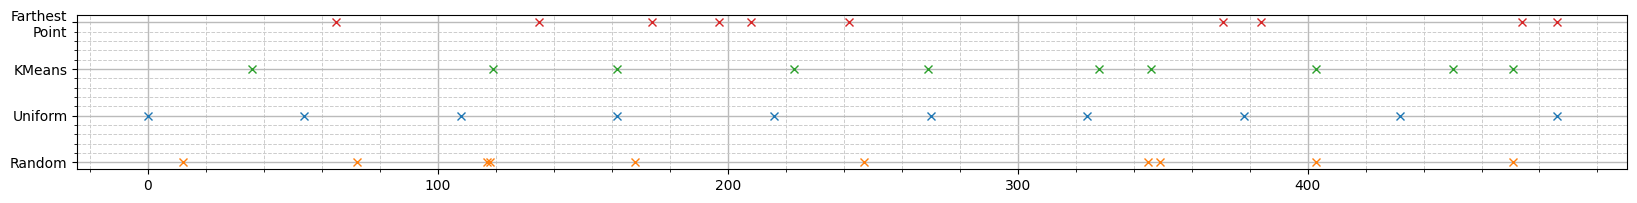

In [20]:
plt.figure(figsize=(20,2))
plt.plot(uniform_N_samples, np.zeros_like(uniform_N_samples), marker='x', label='Uniform Sampling', linestyle='')
plt.plot(random_N_samples, np.ones_like(random_N_samples)*-1, marker='x', label='Random Sampling', linestyle='')
plt.plot(best_indices_kmeans, np.ones_like(random_N_samples)*1, marker='x', label='KMeans Sampling', linestyle='')
plt.plot(best_indices_farthest_point, np.ones_like(random_N_samples)*2, marker='x', label='Farthest Point Sampling', linestyle='')

plt.yticks([-1,0,1,2],['Random','Uniform','KMeans','Farthest\nPoint'])
# plt.legend()
# plt.minorticks_on()
plt.xticks(np.arange(0,len(valid_files),100))
plt.minorticks_on()
plt.grid(which='major', color='#BBBBBB', linestyle='-', linewidth=1)
plt.grid(which='minor', color='#CCCCCC', linestyle='--', linewidth=0.7)
plt.show()

## Ground Truth Camera Positions

In [21]:
gt = pd.read_csv(GROUNDTRUTH_PATH, sep=" ")
gt = gt.to_numpy()

In [22]:
gt_data = torch.tensor(gt[:MAX_IMAGE_FILES,1:8])

In [23]:
uniform_data = gt_data[uniform_N_samples]
random_data = gt_data[random_N_samples]
kmeans_data = gt_data[best_indices_kmeans]
farthest_data = gt_data[best_indices_farthest_point]

In [24]:
def rotation_matrix_to_quaternion(R):
    """
    Convert a batch of 3x3 rotation matrices to quaternions.
    R: (..., 3, 3)
    Returns quaternion (..., 4) in (qx, qy, qz, qw) format.
    """
    # Based on Shoemake’s conversion
    qw = torch.sqrt(1.0 + R[...,0,0] + R[...,1,1] + R[...,2,2] + 1e-8) / 2
    qx = (R[...,2,1] - R[...,1,2]) / (4*qw)
    qy = (R[...,0,2] - R[...,2,0]) / (4*qw)
    qz = (R[...,1,0] - R[...,0,1]) / (4*qw)

    q = torch.stack([qx, qy, qz, qw], dim=-1)
    return F.normalize(q, dim=-1)   # normalize quaternion

def extrinsic_to_pose_parameters(extrinsic):
    """
    extrinsic: (1, 5, 3, 4)
    Returns (5, 7) as [tx, ty, tz, qx, qy, qz, qw]
    """
    # Remove the batch dimension → (5, 3, 4)
    extrinsic = extrinsic.squeeze(0)

    R = extrinsic[..., :3]      # (5, 3, 3)
    t = extrinsic[..., 3]       # (5, 3)

    q = rotation_matrix_to_quaternion(R)  # (5, 4)

    # concatenate translation and quaternion
    pose = torch.cat([t, q], dim=-1)  # (5, 7)
    return pose

def quat_to_rotmat(q):
    """
    q = (...,4) in (qx, qy, qz, qw) format
    """
    qx, qy, qz, qw = q.unbind(-1)

    # Elements
    xx = qx*qx; yy = qy*qy; zz = qz*qz
    xy = qx*qy; xz = qx*qz; yz = qy*qz
    wx = qw*qx; wy = qw*qy; wz = qw*qz

    R = torch.stack([
        1 - 2*(yy + zz),  2*(xy - wz),      2*(xz + wy),
        2*(xy + wz),      1 - 2*(xx + zz),  2*(yz - wx),
        2*(xz - wy),      2*(yz + wx),      1 - 2*(xx + yy),
    ], dim=-1).reshape(q.shape[:-1] + (3,3))

    return R

def poses_to_matrices(poses):
    """
    poses: (N,7)
    returns (N,3,4) extrinsics
    """
    t = poses[:, :3]
    q = poses[:, 3:]
    R = quat_to_rotmat(q)
    return torch.cat([R, t.unsqueeze(-1)], dim=-1)

def umeyama_alignment(X, Y):
    """
    X: (N,3) points from traj A
    Y: (N,3) points from traj B
    Solves for similarity transform Y = s R X + t
    Returns s, R, t
    """
    assert X.shape == Y.shape

    mu_X = X.mean(0)
    mu_Y = Y.mean(0)

    Xc = X - mu_X
    Yc = Y - mu_Y

    C = Xc.t() @ Yc / X.shape[0]

    U, D, Vt = torch.linalg.svd(C)
    R = Vt.t() @ U.t()

    if torch.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt.t() @ U.t()

    var_X = (Xc**2).sum() / X.shape[0]
    s = (D.sum() / var_X)

    t = mu_Y - s * (R @ mu_X)

    return s, R, t
def camera_centers(extr):
    R = extr[:, :3, :3]
    t = extr[:, :3, 3]
    C = -(R.transpose(1,2) @ t.unsqueeze(-1)).squeeze(-1)
    return C
def apply_alignment(s, R, t, centers):
    return (s * (centers @ R.t())) + t
def ate_rmse(A_aligned, B):
    return torch.norm(A_aligned - B, dim=1).mean().sqrt()
def trajectory_similarity(A_ext, B_ext):
    # # 1. Convert to extrinsic matrices
    # A_ext = poses_to_matrices(A_poses)
    # B_ext = poses_to_matrices(B_poses)

    # 2. Compute camera centers
    A_centers = camera_centers(A_ext)
    B_centers = camera_centers(B_ext)

    # 3. Similarity alignment
    s, R, t = umeyama_alignment(A_centers, B_centers)

    # 4. Apply alignment
    A_aligned = apply_alignment(s, R, t, A_centers)

    # 5. Compute errors
    ate = torch.norm(A_aligned - B_centers, dim=1).mean()

    return {
        "scale": s,
        "rotation_alignment": R,
        "translation_alignment": t,
        "ATE": ate.item(),
        "A_centers": A_aligned,
        "B_centers": B_centers
    }


In [25]:
gt_extrinsic = poses_to_matrices(gt_data)
uniform_extrinsic = poses_to_matrices(uniform_data)
random_extrinsic = poses_to_matrices(random_data)
kmeans_extrinsic = poses_to_matrices(kmeans_data)
farthest_extrinsic = poses_to_matrices(farthest_data)

In [26]:
gt_camera_centers = camera_centers(gt_extrinsic)
uniform_camera_centers = camera_centers(uniform_extrinsic)
random_camera_centers = camera_centers(random_extrinsic)
kmeans_camera_centers = camera_centers(kmeans_extrinsic)
farthest_camera_centers = camera_centers(farthest_extrinsic)

In [27]:
gt_camera_centers.shape

torch.Size([487, 3])

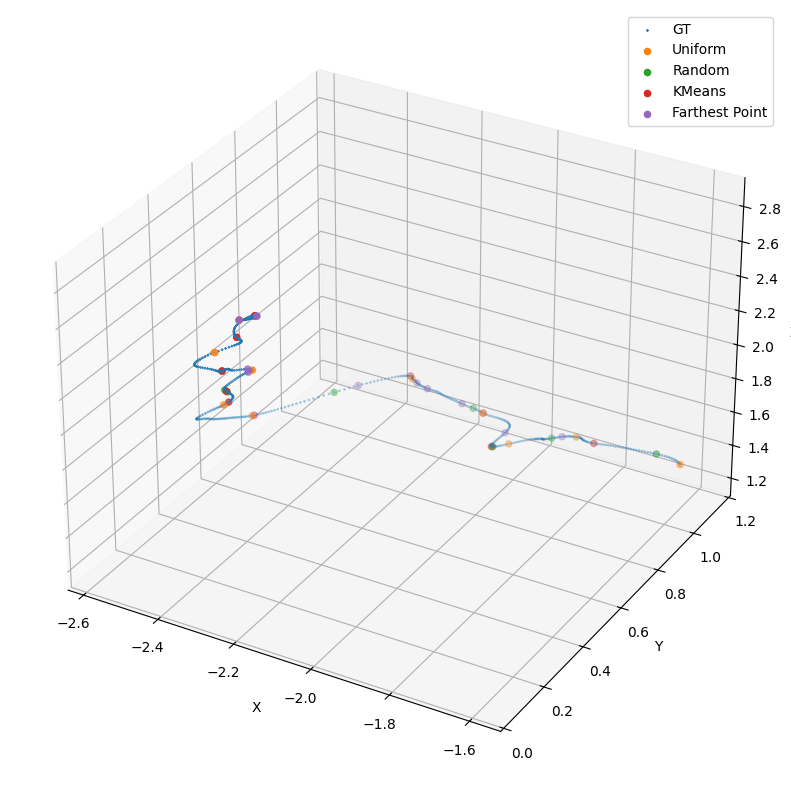

In [28]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# Ground truth
ax.scatter(
    gt_camera_centers[:,0],  # x
    gt_camera_centers[:,1],  # y
    gt_camera_centers[:,2],  # z
    marker='x', s=1, label='GT'
)

# Uniform
ax.scatter(
    uniform_camera_centers[:,0],
    uniform_camera_centers[:,1],
    uniform_camera_centers[:,2],
    marker='o', s=20, label='Uniform'
)

# Random
ax.scatter(
    random_camera_centers[:,0],
    random_camera_centers[:,1],
    random_camera_centers[:,2],
    marker='o', s=20, label='Random'
)

# KMeans
ax.scatter(
    kmeans_camera_centers[:,0],
    kmeans_camera_centers[:,1],
    kmeans_camera_centers[:,2],
    marker='o', s=20, label='KMeans'
)

# Farthest Point
ax.scatter(
    farthest_camera_centers[:,0],
    farthest_camera_centers[:,1],
    farthest_camera_centers[:,2],
    marker='o', s=20, label='Farthest Point'
)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

ax.legend()
plt.show()


In [29]:
import plotly.graph_objects as go

fig = go.Figure()

# Ground truth
fig.add_trace(go.Scatter3d(
    x=gt_camera_centers[:,0],
    y=gt_camera_centers[:,1],
    z=gt_camera_centers[:,2],
    mode='markers',
    marker=dict(size=3, symbol='circle'),
    name='GT'
))

# Uniform
fig.add_trace(go.Scatter3d(
    x=uniform_camera_centers[:,0],
    y=uniform_camera_centers[:,1],
    z=uniform_camera_centers[:,2],
    mode='markers',
    marker=dict(size=3, symbol='x'),
    name='Uniform'
))

# Random
fig.add_trace(go.Scatter3d(
    x=random_camera_centers[:,0],
    y=random_camera_centers[:,1],
    z=random_camera_centers[:,2],
    mode='markers',
    marker=dict(size=3, symbol='x'),
    name='Random'
))

# KMeans
fig.add_trace(go.Scatter3d(
    x=kmeans_camera_centers[:,0],
    y=kmeans_camera_centers[:,1],
    z=kmeans_camera_centers[:,2],
    mode='markers',
    marker=dict(size=3, symbol='x'),
    name='KMeans'
))

# Farthest Point
fig.add_trace(go.Scatter3d(
    x=farthest_camera_centers[:,0],
    y=farthest_camera_centers[:,1],
    z=farthest_camera_centers[:,2],
    mode='markers',
    marker=dict(size=3, symbol='x'),
    name='Farthest Point'
))

fig.update_layout(
    width=800,
    height=800,
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    )
)

fig.show()


## VGGT Predictions

In [30]:
uniform_N_samples, random_N_samples, best_indices_kmeans, best_indices_farthest_point

(array([  0,  54, 108, 162, 216, 270, 324, 378, 432, 486]),
 array([349, 471,  12, 117, 168, 403, 345, 118, 247,  72]),
 array([ 36, 119, 162, 223, 269, 328, 346, 403, 450, 471]),
 array([ 65, 135, 174, 197, 208, 242, 371, 384, 474, 486]))

In [31]:
import os
image_dir = IMAGES_PATH
image_list_dir = np.array(os.listdir(image_dir))
image_list_dir.sort()
all_image_paths = [os.path.join(image_dir, f) for f in image_list_dir]
uniform_sample_paths = [os.path.join(image_dir, f) for f in image_list_dir[uniform_N_samples]]
random_sample_paths = [os.path.join(image_dir, f) for f in image_list_dir[random_N_samples]]
kmeans_sample_paths = [os.path.join(image_dir, f) for f in image_list_dir[best_indices_kmeans]]
farthest_sample_paths = [os.path.join(image_dir, f) for f in image_list_dir[best_indices_farthest_point]]

In [32]:
# num_images = 30
# image_names = [os.path.join(image_dir, f) for f in image_list_dir[:num_images]]
# images = load_and_preprocess_images(image_names).to(device)

uniform_sample_images = load_and_preprocess_images(uniform_sample_paths).to(device)
random_sample_images = load_and_preprocess_images(random_sample_paths).to(device)
kmeans_sample_images = load_and_preprocess_images(kmeans_sample_paths).to(device)
farthest_sample_images = load_and_preprocess_images(farthest_sample_paths).to(device)


In [33]:
import gc

In [34]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
with torch.no_grad():
    with torch.cuda.amp.autocast(dtype=dtype):
        # Predict attributes including cameras, depth maps, and point maps.
        predictions_uniform = model(uniform_sample_images)
        gc.collect()
        torch.cuda.empty_cache()
        predictions_random = model(random_sample_images)
        gc.collect()
        torch.cuda.empty_cache()
        predictions_kmeans = model(kmeans_sample_images)
        gc.collect()
        torch.cuda.empty_cache()
        predictions_farthest = model(farthest_sample_images)
        gc.collect()
        torch.cuda.empty_cache()


### Camera Trajectory Evaluation

In [35]:
vggt_uniform_extrinsic, _ = pose_encoding_to_extri_intri(predictions_uniform['pose_enc'], uniform_sample_images.shape[-2:])
vggt_uniform_extrinsic_cpu = vggt_uniform_extrinsic.squeeze(0).to('cpu').float()
vggt_random_extrinsic, _ = pose_encoding_to_extri_intri(predictions_random['pose_enc'], random_sample_images.shape[-2:])
vggt_random_extrinsic_cpu = vggt_random_extrinsic.squeeze(0).to('cpu').float()
vggt_kmeans_extrinsic, _ = pose_encoding_to_extri_intri(predictions_kmeans['pose_enc'], kmeans_sample_images.shape[-2:])
vggt_kmeans_extrinsic_cpu = vggt_kmeans_extrinsic.squeeze(0).to('cpu').float()
vggt_farthest_extrinsic, _ = pose_encoding_to_extri_intri(predictions_farthest['pose_enc'], farthest_sample_images.shape[-2:])
vggt_farthest_extrinsic_cpu = vggt_farthest_extrinsic.squeeze(0).to('cpu').float()


NameError: name 'predictions_uniform' is not defined

In [ ]:
# extrinsic_cpu = extrinsic.squeeze(0).to('cpu').float()
uniform_comparision = trajectory_similarity(uniform_extrinsic.float(), vggt_uniform_extrinsic_cpu)
random_comparision = trajectory_similarity(random_extrinsic.float(), vggt_random_extrinsic_cpu)
kmeans_comparision = trajectory_similarity(kmeans_extrinsic.float(), vggt_kmeans_extrinsic_cpu)
farthest_comparision = trajectory_similarity(farthest_extrinsic.float(), vggt_farthest_extrinsic_cpu)

In [ ]:
uniform_comparision['ATE'], random_comparision['ATE'], kmeans_comparision['ATE'], farthest_comparision['ATE']

(0.23031342029571533,
 0.22301948070526123,
 0.20543913543224335,
 0.21599134802818298)

In [ ]:
methods = ["uniform", "random", "kmeans", "farthest"]
ates = [
    uniform_comparision['ATE'],
    random_comparision['ATE'],
    kmeans_comparision['ATE'],
    farthest_comparision['ATE']
]

# Print header
print("\t".join(methods))

# Print values row
print("\t".join(str(x) for x in ates))

uniform	random	kmeans	farthest
0.23031342029571533	0.22301948070526123	0.20543913543224335	0.21599134802818298


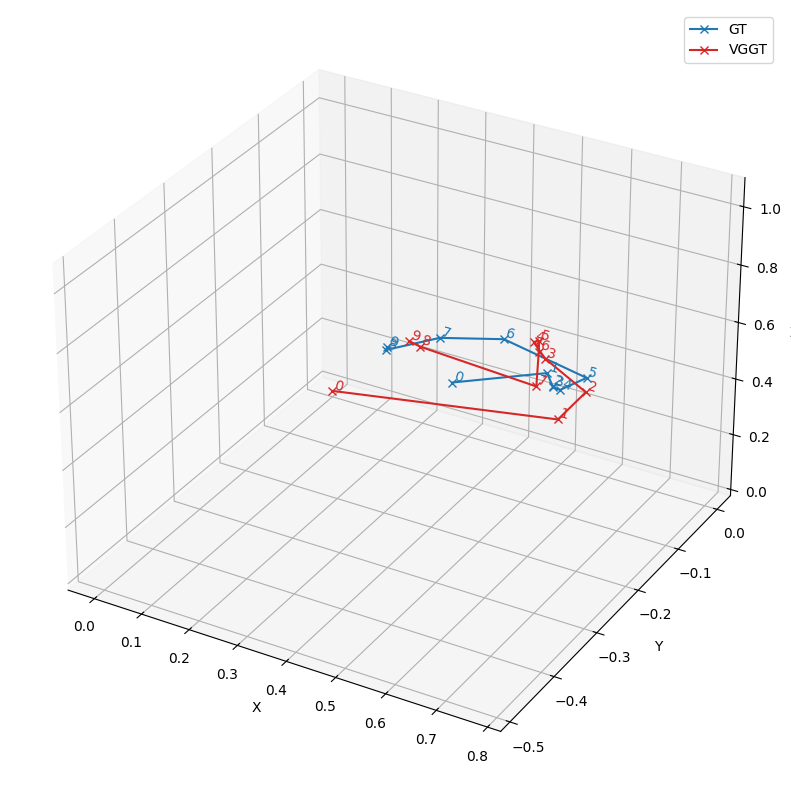

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assume 'farthest_comparision', 'farthest_extrinsic',
# 'vggt_farthest_extrinsic_cpu', and 'trajectory_similarity' are defined elsewhere

gt_centers = farthest_comparision['A_centers']
vggt_centers = farthest_comparision['B_centers']
gt_ext = farthest_extrinsic.float()
vggt_ext_cpu = vggt_farthest_extrinsic_cpu

# ======================================================

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# --- Plot GT trajectory and add index annotations ---
ax.plot(
    gt_centers[:,0], # X
    gt_centers[:,1], # Y
    gt_centers[:,2], # Z
    marker='x', linestyle='-', color='tab:blue', label='GT'
)
for i in range(len(gt_centers)):
    # Annotate each point (X, Y, Z, text_label)
    ax.text(
        gt_centers[i, 0],
        gt_centers[i, 1],
        gt_centers[i, 2],
        str(i), # The index number as text
        color='tab:blue',
        size=10,
        zdir='x' # Optional: helps with text orientation in 3D
    )

# --- Plot VGGT trajectory and add index annotations ---
ax.plot(
    vggt_centers[:,0], # X
    vggt_centers[:,1], # Y
    vggt_centers[:,2], # Z
    marker='x', linestyle='-', color='tab:red', label='VGGT'
)
for i in range(len(vggt_centers)):
    # Annotate each point (X, Y, Z, text_label)
    ax.text(
        vggt_centers[i, 0],
        vggt_centers[i, 1],
        vggt_centers[i, 2],
        str(i), # The index number as text
        color='tab:red',
        size=10,
        zdir='x' # Optional: helps with text orientation in 3D
    )

skip = trajectory_similarity(gt_ext, vggt_ext_cpu)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
ax.grid(True)
plt.show()


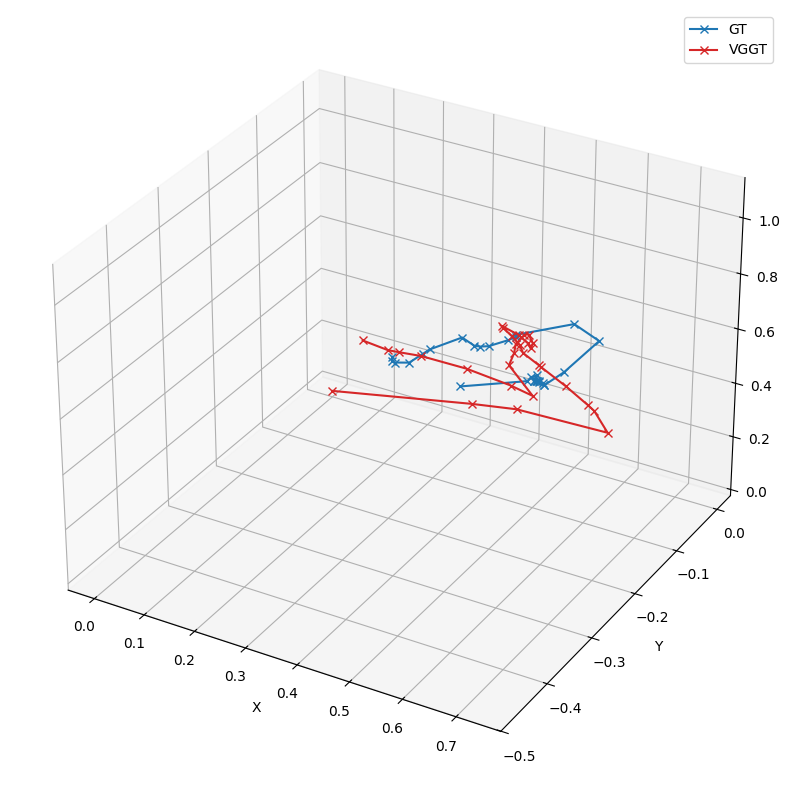

In [ ]:
gt_centers = farthest_comparision['A_centers']
vggt_centers = farthest_comparision['B_centers']
gt_ext = farthest_extrinsic.float()
vggt_ext_cpu = vggt_farthest_extrinsic_cpu

# ======================================================
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# GT trajectory
ax.plot(
    gt_centers[:,0],   # X
    gt_centers[:,1],   # Y
    gt_centers[:,2],   # Z  <-- added for 3D
    marker='x',
    linestyle='-',
    color='tab:blue',
    label='GT'
)

# VGGT trajectory
ax.plot(
    vggt_centers[:,0],  # X
    vggt_centers[:,1],  # Y
    vggt_centers[:,2],  # Z
    marker='x',
    linestyle='-',
    color='tab:red',
    label='VGGT'
)

skip = trajectory_similarity(gt_ext, vggt_ext_cpu)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

ax.legend()
ax.grid(True)

plt.show()


##Quantize

####old

In [35]:
# ----------------- RAM-SAFE FULL QUANTIZER (auto-channel axis) -----------------
import torch, numpy as np, gc, math, os
from pathlib import Path

# ---------------- CONFIG ----------------
BITS = 8
MAX_INT = (2**(BITS-1)) - 1  # 127
SIZE_THRESHOLD = 512
VAR_THRESHOLD = 1e-8
OUTLIER_RATIO_THRESH = 50.0
MEAN_RESIDUAL_VAR_THRESH = 1e-6   # median(res_var/mean^2) threshold for per-channel split
SAVE_QDICT_PATH = "/content/vggt_qdict_full.pt"
CHANNEL_AXIS_AUTO = True  # we will auto-detect per-tensor
# ----------------------------------------

def get_stats_np(arr):
    """Return quick stats for numpy array arr."""
    mean = float(np.mean(arr))
    var = float(np.var(arr))
    std = math.sqrt(var) if var>0 else 0.0
    absmax = float(np.max(np.abs(arr)))
    medabs = float(np.median(np.abs(arr)) + 1e-12)
    outlier_ratio = absmax / medabs if medabs>0 else float('inf')
    size = arr.size
    return {"mean":mean, "var":var, "std":std, "absmax":absmax,
            "medabs":medabs, "outlier_ratio":outlier_ratio, "size":size}

def decide_fp16_or_int8(name, arr_np):
    """Decide plan for a numpy tensor: 'fp16' or 'int8' following rules."""
    lname = name.lower()
    stats = get_stats_np(arr_np)
    # name-based sensitive layers -> FP16
    sensitive_keys = ["patch", "embed", "pos", "position", "norm", "ln", "depth", "pose", "head"]
    if any(k in lname for k in sensitive_keys):
        return "fp16", stats
    # stats-based rules
    if stats["size"] < SIZE_THRESHOLD:
        return "fp16", stats
    if stats["var"] < VAR_THRESHOLD:
        return "fp16", stats
    if stats["outlier_ratio"] > OUTLIER_RATIO_THRESH:
        return "fp16", stats
    # otherwise int8 candidate
    return "int8", stats

def detect_channel_axis(arr_np):
    """
    Heuristic to pick a channel axis for per-channel quant:
    - If 2D: choose axis 0 (out_features)
    - If >2D: choose axis with largest dimension (likely output channel)
    - If 1D or scalar: return -1 (no per-channel)
    """
    if arr_np.ndim == 1:
        return -1
    if arr_np.ndim == 2:
        return 0
    # choose axis of max size
    axis = int(np.argmax(arr_np.shape))
    return axis

def try_per_channel_mean_split(arr_np, channel_axis):
    """
    Try per-channel mean split.
    Returns (mean, residual_np, mean_kind)
      - mean: None or scalar or 1D np.array per-channel
      - residual_np: numpy array (same shape) (residual = arr - mean_broadcast)
      - mean_kind: 'per_channel','scalar','none'
    """
    if channel_axis is not None and channel_axis >=0 and arr_np.ndim >=2:
        axes = tuple(i for i in range(arr_np.ndim) if i != channel_axis)
        # per-channel mean (shape = (C,))
        ch_means = np.mean(arr_np, axis=axes)
        # broadcast back and compute residual
        reshape = [1]*arr_np.ndim
        reshape[channel_axis] = ch_means.shape[0]
        chmeans_r = ch_means.reshape(tuple(reshape))
        residual = arr_np - chmeans_r
        # per-channel residual var
        ch_var = np.var(residual, axis=axes)
        mean_mag_sq = np.maximum(ch_means**2, 1e-12)
        ratio = ch_var / mean_mag_sq
        # use median ratio as robust indicator
        ratio_med = float(np.median(ratio))
        if ratio_med < MEAN_RESIDUAL_VAR_THRESH:
            return ch_means.astype(np.float32), residual.astype(np.float32), "per_channel"
        # else fallthrough to scalar mean attempt
    # scalar mean
    mean_scalar = float(np.mean(arr_np))
    residual_scalar = arr_np - mean_scalar
    res_var = float(np.var(residual_scalar))
    if res_var < MEAN_RESIDUAL_VAR_THRESH * max(1.0, mean_scalar*mean_scalar):
        return mean_scalar, residual_scalar.astype(np.float32), "scalar"
    return None, arr_np.astype(np.float32), "none"

def per_channel_quantize_np(res_np, channel_axis):
    """
    Quantize numpy residual array per-channel along channel_axis.
    Returns q (np.int8), scales (np.float32 1D), per_channel=True
    If channel_axis <0 or ndim<2 -> fallback to per-tensor quantization
    """
    if res_np.ndim < 2 or channel_axis < 0:
        # per-tensor
        absmax = float(np.max(np.abs(res_np)))
        scale = absmax / MAX_INT if absmax>0 else 1.0
        q = np.clip(np.round(res_np / scale), -MAX_INT, MAX_INT).astype(np.int8)
        return q, np.array([scale], dtype=np.float32), False
    # compute max per channel
    axes = tuple(i for i in range(res_np.ndim) if i != channel_axis)
    max_c = np.max(np.abs(res_np), axis=axes)
    max_c[max_c==0] = 1.0
    scales = (max_c / MAX_INT).astype(np.float32)  # shape (C,)
    # broadcast scales
    reshape = [1]*res_np.ndim
    reshape[channel_axis] = res_np.shape[channel_axis]
    scales_r = scales.reshape(tuple(reshape))
    qf = np.round(res_np / scales_r)
    qf = np.clip(qf, -MAX_INT, MAX_INT).astype(np.int8)
    return qf, scales, True

def per_tensor_quantize_np(res_np):
    absmax = float(np.max(np.abs(res_np)))
    scale = absmax / MAX_INT if absmax>0 else 1.0
    q = np.clip(np.round(res_np / scale), -MAX_INT, MAX_INT).astype(np.int8)
    return q, float(scale), False

# ----------------- streaming analyzer + quantizer -----------------
from tqdm import tqdm

def analyze_and_quantize_streaming(model, save_path=SAVE_QDICT_PATH):
    qdict = {}
    total_params = 0
    int8_count = 0
    fp16_count = 0

    # Count number of parameters for progress bar
    num_layers = sum(1 for _ in model.named_parameters())

    with torch.no_grad():

        # Wrap iteration in tqdm
        for name, param in tqdm(model.named_parameters(),
                                total=num_layers,
                                desc="Quantizing VGGT",
                                ncols=100):

            # load param as numpy (single tensor)
            arr = param.detach().cpu().numpy()
            total_params += arr.size

            plan, stats = decide_fp16_or_int8(name, arr)

            # ---------------- FP16 --------------------
            if plan == "fp16":
                qdict[name] = {
                    "dtype": "fp16",
                    "shape": arr.shape,
                    "value": arr.astype(np.float16)
                }
                fp16_count += arr.size
                del arr
                gc.collect()
                continue

            # ---------------- INT8 --------------------
            ch_axis = detect_channel_axis(arr) if CHANNEL_AXIS_AUTO else 0

            mean, residual_np, mean_kind = try_per_channel_mean_split(arr, ch_axis)
            del arr
            gc.collect()

            # ---- Correct per-channel/per-tensor quant ----
            if isinstance(residual_np, np.ndarray):
                if residual_np.ndim >= 2 and ch_axis >= 0:
                    q, scales, is_pc = per_channel_quantize_np(residual_np, ch_axis)
                else:
                    q, scales, is_pc = per_tensor_quantize_np(residual_np)
            else:
                residual_np = np.array(residual_np)
                q, scales, is_pc = per_tensor_quantize_np(residual_np)

            # Store compact INT8 entry
            entry = {
                "dtype": "int8",
                "shape": tuple(residual_np.shape),
                "qweight": q,
                "scale": scales,
                "mean": mean,
                "mean_kind": mean_kind,
                "per_channel": bool(is_pc),
                "channel_axis": int(ch_axis) if ch_axis is not None else -1
            }

            qdict[name] = entry
            int8_count += q.size

            # free
            del residual_np, q, scales
            gc.collect()

    # Save everything
    torch.save(qdict, save_path)
    print(f"\nSaved quantized dict to: {save_path}")
    print(f"Total params: {total_params:,}")
    print(f"INT8 elements stored: {int8_count:,}")
    print(f"FP16 elements stored: {fp16_count:,}")

    return qdict

# ------------- helper to reload & apply one-by-one (RAM-safe) -------------
def apply_qdict_to_model_lazy(model, qdict_path, device=None, dtype=torch.float16):
    """
    Loads qdict and applies dequantized weights to model in a streaming fashion,
    assigning each parameter one-by-one to avoid holding whole state in memory.
    """
    qdict = torch.load(qdict_path, map_location="cpu")
    with torch.no_grad():
        for name, param in model.named_parameters():
            info = qdict.get(name, None)
            if info is None:
                continue
            if info["dtype"] == "fp16":
                arr = info["value"].astype(np.float32)
                param.data = torch.from_numpy(arr).to(device if device else param.device).type(dtype)
                # free arr
                del arr
            else:
                # INT8: reconstruct
                if info["per_channel"]:
                    q = info["qweight"].astype(np.float32)
                    scales = info["scale"].astype(np.float32) if isinstance(info["scale"], np.ndarray) else np.array([info["scale"]], dtype=np.float32)
                    ch_axis = info.get("channel_axis", 0)
                    # broadcast scales
                    shape = info["shape"]
                    reshape = [1]*len(shape)
                    reshape[ch_axis] = scales.shape[0]
                    scales_r = scales.reshape(tuple(reshape))
                    arr = q * scales_r
                else:
                    arr = info["qweight"].astype(np.float32) * float(info["scale"])
                # add mean if present
                if info.get("mean", None) is not None:
                    m = info["mean"]
                    if info["mean_kind"] == "per_channel":
                        m_arr = np.array(m, dtype=np.float32)
                        shape = info["shape"]
                        reshape = [1]*len(shape)
                        reshape[info["channel_axis"]] = m_arr.shape[0]
                        m_r = m_arr.reshape(tuple(reshape))
                        arr = arr + m_r
                    else:
                        arr = arr + float(m)
                # assign
                param.data = torch.from_numpy(arr).to(device if device else param.device).type(dtype)
                # free arr
                del arr
            gc.collect()
    print("Applied qdict to model (lazy assign).")
    return model

# ---------------- USAGE ----------------
# Example:
# qdict = analyze_and_quantize_streaming(model, save_path=SAVE_QDICT_PATH)
# model_q = apply_qdict_to_model_lazy(model_copy_or_new(), SAVE_QDICT_PATH, device='cuda')
# -------------------------------------------------


####new

In [34]:
# ----------------- RAM-SAFE FULL QUANTIZER (auto-channel axis) -----------------
import torch, numpy as np, gc, math, os
from pathlib import Path

# ---------------- CONFIG ----------------
BITS = 8
MAX_INT = (2**(BITS-1)) - 1  # 127
SIZE_THRESHOLD = 512
VAR_THRESHOLD = 1e-8
OUTLIER_RATIO_THRESH = 50.0
MEAN_RESIDUAL_VAR_THRESH = 1e-6   # median(res_var/mean^2) threshold for per-channel split
SAVE_QDICT_PATH = "/content/vggt_qdict_full.pt"
CHANNEL_AXIS_AUTO = True  # we will auto-detect per-tensor
# ----------------------------------------

def get_stats_np(arr):
    """Return quick stats for numpy array arr."""
    mean = float(np.mean(arr))
    var = float(np.var(arr))
    std = math.sqrt(var) if var>0 else 0.0
    absmax = float(np.max(np.abs(arr)))
    medabs = float(np.median(np.abs(arr)) + 1e-12)
    outlier_ratio = absmax / medabs if medabs>0 else float('inf')
    size = arr.size
    return {"mean":mean, "var":var, "std":std, "absmax":absmax,
            "medabs":medabs, "outlier_ratio":outlier_ratio, "size":size}

def decide_fp16_or_int8(name, arr_np):
    """Decide plan for a numpy tensor: 'fp16' or 'int8' following rules."""
    lname = name.lower()
    stats = get_stats_np(arr_np)
    # name-based sensitive layers -> FP16
    sensitive_keys = ["patch", "embed", "pos", "position", "norm", "ln", "depth", "pose", "head"]
    if any(k in lname for k in sensitive_keys):
        return "fp16", stats
    # stats-based rules
    if stats["size"] < SIZE_THRESHOLD:
        return "fp16", stats
    if stats["var"] < VAR_THRESHOLD:
        return "fp16", stats
    if stats["outlier_ratio"] > OUTLIER_RATIO_THRESH:
        return "fp16", stats
    # otherwise int8 candidate
    return "int8", stats

def detect_channel_axis(arr_np):
    """
    Heuristic to pick a channel axis for per-channel quant:
    - If 2D: choose axis 0 (out_features)
    - If >2D: choose axis with largest dimension (likely output channel)
    - If 1D or scalar: return -1 (no per-channel)
    """
    if arr_np.ndim == 1:
        return -1
    if arr_np.ndim == 2:
        return 0
    # choose axis of max size
    axis = int(np.argmax(arr_np.shape))
    return axis

def try_per_channel_mean_split(arr_np, channel_axis):
    """
    Try per-channel mean split.
    Returns (mean, residual_np, mean_kind)
      - mean: None or scalar or 1D np.array per-channel
      - residual_np: numpy array (same shape) (residual = arr - mean_broadcast)
      - mean_kind: 'per_channel','scalar','none'
    """
    if channel_axis is not None and channel_axis >=0 and arr_np.ndim >=2:
        axes = tuple(i for i in range(arr_np.ndim) if i != channel_axis)
        # per-channel mean (shape = (C,))
        ch_means = np.mean(arr_np, axis=axes)
        # broadcast back and compute residual
        reshape = [1]*arr_np.ndim
        reshape[channel_axis] = ch_means.shape[0]
        chmeans_r = ch_means.reshape(tuple(reshape))
        residual = arr_np - chmeans_r
        # per-channel residual var
        ch_var = np.var(residual, axis=axes)
        mean_mag_sq = np.maximum(ch_means**2, 1e-12)
        ratio = ch_var / mean_mag_sq
        # use median ratio as robust indicator
        ratio_med = float(np.median(ratio))
        if ratio_med < MEAN_RESIDUAL_VAR_THRESH:
            return ch_means.astype(np.float32), residual.astype(np.float32), "per_channel"
        # else fallthrough to scalar mean attempt
    # scalar mean
    mean_scalar = float(np.mean(arr_np))
    residual_scalar = arr_np - mean_scalar
    res_var = float(np.var(residual_scalar))
    if res_var < MEAN_RESIDUAL_VAR_THRESH * max(1.0, mean_scalar*mean_scalar):
        return mean_scalar, residual_scalar.astype(np.float32), "scalar"
    return None, arr_np.astype(np.float32), "none"

def per_channel_quantize_np(res_np, channel_axis):
    """
    Quantize numpy residual array per-channel along channel_axis.
    Returns q (np.int8), scales (np.float32 1D), per_channel=True
    If channel_axis <0 or ndim<2 -> fallback to per-tensor quantization
    """
    if res_np.ndim < 2 or channel_axis < 0:
        # per-tensor
        absmax = float(np.max(np.abs(res_np)))
        scale = absmax / MAX_INT if absmax>0 else 1.0
        q = np.clip(np.round(res_np / scale), -MAX_INT, MAX_INT).astype(np.int8)
        return q, np.array([scale], dtype=np.float32), False
    # compute max per channel
    axes = tuple(i for i in range(res_np.ndim) if i != channel_axis)
    max_c = np.max(np.abs(res_np), axis=axes)
    max_c[max_c==0] = 1.0
    scales = (max_c / MAX_INT).astype(np.float32)  # shape (C,)
    # broadcast scales
    reshape = [1]*res_np.ndim
    reshape[channel_axis] = res_np.shape[channel_axis]
    scales_r = scales.reshape(tuple(reshape))
    qf = np.round(res_np / scales_r)
    qf = np.clip(qf, -MAX_INT, MAX_INT).astype(np.int8)
    return qf, scales, True

def per_tensor_quantize_np(res_np):
    absmax = float(np.max(np.abs(res_np)))
    scale = absmax / MAX_INT if absmax>0 else 1.0
    q = np.clip(np.round(res_np / scale), -MAX_INT, MAX_INT).astype(np.int8)
    return q, float(scale), False

# ----------------- streaming analyzer + quantizer -----------------
from tqdm import tqdm

def analyze_and_quantize_streaming(model, save_dir="/content/vggt_qdict_full"):
    """
    Fully streaming: saves each quantized tensor as an individual .pt file.
    No big qdict is ever kept in RAM. No torch.save(qdict).
    """
    os.makedirs(save_dir, exist_ok=True)

    total_params = 0
    fp16_count = 0
    int8_count = 0

    num_layers = sum(1 for _ in model.named_parameters())

    with torch.no_grad():
        for name, param in tqdm(model.named_parameters(), total=num_layers,
                                desc="Quantizing VGGT", ncols=100):

            arr = param.detach().cpu().numpy()
            total_params += arr.size

            plan, stats = decide_fp16_or_int8(name, arr)

            # ---------------- FP16 ----------------
            if plan == "fp16":
                entry = {
                    "dtype": "fp16",
                    "shape": arr.shape,
                    "value": arr.astype(np.float16)
                }
                torch.save(entry, f"{save_dir}/{name}.pt")
                fp16_count += arr.size

                del arr, entry
                gc.collect()
                continue

            # ---------------- INT8 ----------------
            ch_axis = detect_channel_axis(arr) if CHANNEL_AXIS_AUTO else 0

            mean, residual_np, mean_kind = try_per_channel_mean_split(arr, ch_axis)
            del arr
            gc.collect()

            if isinstance(residual_np, np.ndarray):
                if residual_np.ndim >= 2 and ch_axis >= 0:
                    q, scales, is_pc = per_channel_quantize_np(residual_np, ch_axis)
                else:
                    q, scales, is_pc = per_tensor_quantize_np(residual_np)
            else:
                residual_np = np.array(residual_np)
                q, scales, is_pc = per_tensor_quantize_np(residual_np)

            entry = {
                "dtype": "int8",
                "shape": tuple(residual_np.shape),
                "qweight": q,
                "scale": scales,
                "mean": mean,
                "mean_kind": mean_kind,
                "per_channel": bool(is_pc),
                "channel_axis": int(ch_axis) if ch_axis is not None else -1,
            }

            torch.save(entry, f"{save_dir}/{name}.pt")
            int8_count += q.size

            del residual_np, q, scales, entry
            gc.collect()

    print("\nDone quantizing.")
    print(f"Saved to: {save_dir}")
    print(f"Total params: {total_params:,}")
    print(f"INT8 stored: {int8_count:,}")
    print(f"FP16 stored: {fp16_count:,}")


# ------------- helper to reload & apply one-by-one (RAM-safe) -------------
def apply_qdict_to_model_lazy(model, save_dir, device=None, dtype=torch.float16):

    with torch.no_grad():
        for name, param in model.named_parameters():

            path = f"{save_dir}/{name}.pt"
            if not os.path.exists(path):
                continue

            info = torch.load(path, map_location="cpu")

            if info["dtype"] == "fp16":
                arr = info["value"].astype(np.float32)

            else:
                if info["per_channel"]:
                    q = info["qweight"].astype(np.float32)
                    scales = info["scale"].astype(np.float32) if isinstance(info["scale"], np.ndarray) else np.array([info["scale"]], dtype=np.float32)
                    ch_axis = info["channel_axis"]
                    shape = info["shape"]
                    reshape = [1] * len(shape)
                    reshape[ch_axis] = scales.shape[0]
                    scales_r = scales.reshape(tuple(reshape))
                    arr = q * scales_r
                else:
                    arr = info["qweight"].astype(np.float32) * float(info["scale"])

                if info.get("mean") is not None:
                    if info["mean_kind"] == "per_channel":
                        m = np.array(info["mean"], dtype=np.float32)
                        reshape = [1] * len(arr.shape)
                        reshape[info["channel_axis"]] = m.shape[0]
                        arr = arr + m.reshape(tuple(reshape))
                    else:
                        arr = arr + float(info["mean"])

            param.data = torch.from_numpy(arr).to(device if device else param.device).type(dtype)

            del arr, info
            gc.collect()

    print("Loaded quantized VGGT.")
    return model

# ---------------- USAGE ----------------
# Example:
# qdict = analyze_and_quantize_streaming(model, save_path=SAVE_QDICT_PATH)
# model_q = apply_qdict_to_model_lazy(model_copy_or_new(), SAVE_QDICT_PATH, device='cuda')
# -------------------------------------------------


In [35]:
# ---------- Replacement functions: ensure sensitive layers remain FP32 ----------
from tqdm import tqdm

SENSITIVE_KEYS = ["patch", "embed", "pos", "position", "norm", "ln", "layernorm", "depth", "pose", "head", "bias"]

def decide_fp32_or_int8(name, arr_np):
    """
    Decide plan for a numpy tensor: 'fp32' or 'int8' following rules.
    Sensitive names -> 'fp32' (explicit)
    """
    lname = name.lower()
    stats = get_stats_np(arr_np)
    # name-based sensitive layers -> FP32
    if any(k in lname for k in SENSITIVE_KEYS):
        return "fp32", stats
    # stats-based rules
    if stats["size"] < SIZE_THRESHOLD:
        return "fp32", stats
    if stats["var"] < VAR_THRESHOLD:
        return "fp32", stats
    if stats["outlier_ratio"] > OUTLIER_RATIO_THRESH:
        return "fp32", stats
    # otherwise int8 candidate
    return "int8", stats

def analyze_and_quantize_streaming(model, save_dir="/content/vggt_qdict_full"):
    """
    Fully streaming: saves each quantized tensor as an individual .pt file.
    Sensitive tensors are saved as FP32 (dtype='fp32'). Others are INT8 entries.
    """
    os.makedirs(save_dir, exist_ok=True)

    total_params = 0
    fp32_count = 0
    int8_count = 0

    num_layers = sum(1 for _ in model.named_parameters())

    with torch.no_grad():
        for name, param in tqdm(model.named_parameters(), total=num_layers,
                                desc="Quantizing VGGT", ncols=100):

            arr = param.detach().cpu().numpy()
            total_params += arr.size

            plan, stats = decide_fp32_or_int8(name, arr)

            # ---------------- FP32 (sensitive) ----------------
            if plan == "fp32":
                entry = {
                    "dtype": "fp32",
                    "shape": arr.shape,
                    "value": arr.astype(np.float32)
                }
                torch.save(entry, f"{save_dir}/{name}.pt")
                fp32_count += arr.size

                del arr, entry
                gc.collect()
                continue

            # ---------------- INT8 ----------------
            ch_axis = detect_channel_axis(arr) if CHANNEL_AXIS_AUTO else 0

            mean, residual_np, mean_kind = try_per_channel_mean_split(arr, ch_axis)
            del arr
            gc.collect()

            if isinstance(residual_np, np.ndarray):
                if residual_np.ndim >= 2 and ch_axis >= 0:
                    q, scales, is_pc = per_channel_quantize_np(residual_np, ch_axis)
                else:
                    q, scales, is_pc = per_tensor_quantize_np(residual_np)
            else:
                residual_np = np.array(residual_np)
                q, scales, is_pc = per_tensor_quantize_np(residual_np)

            entry = {
                "dtype": "int8",
                "shape": tuple(residual_np.shape),
                "qweight": q,
                "scale": scales,
                "mean": mean,
                "mean_kind": mean_kind,
                "per_channel": bool(is_pc),
                "channel_axis": int(ch_axis) if ch_axis is not None else -1,
            }

            torch.save(entry, f"{save_dir}/{name}.pt")
            int8_count += q.size

            del residual_np, q, scales, entry
            gc.collect()

    print("\nDone quantizing.")
    print(f"Saved to: {save_dir}")
    print(f"Total params: {total_params:,}")
    print(f"INT8 stored: {int8_count:,}")
    print(f"FP32 stored: {fp32_count:,}")


def apply_qdict_to_model_lazy(model, save_dir, device=None, default_dtype=torch.float16):
    """
    Loads qdict files from save_dir one param at a time and assigns to model.
    Preserves sensitive params in FP32 (see SENSITIVE_KEYS).
    default_dtype: dtype to use for most dequantized parameters (e.g. torch.float16)
    """
    save_dir = str(save_dir)
    with torch.no_grad():
        for name, param in model.named_parameters():
            path = f"{save_dir}/{name}.pt"
            if not os.path.exists(path):
                continue

            info = torch.load(path, map_location="cpu")

            # Decide final dtype for this param: FP32 for sensitive, else default_dtype
            target_dtype = torch.float32 if any(k in name.lower() for k in SENSITIVE_KEYS) else default_dtype

            if info["dtype"] == "fp32":
                arr = info["value"].astype(np.float32)
                param.data = torch.from_numpy(arr).to(device if device else param.device).type(target_dtype)
                del arr
            else:
                # INT8: reconstruct
                if info["per_channel"]:
                    q = info["qweight"].astype(np.float32)
                    scales = info["scale"].astype(np.float32) if isinstance(info["scale"], np.ndarray) else np.array([info["scale"]], dtype=np.float32)
                    ch_axis = info["channel_axis"]
                    shape = info["shape"]
                    reshape = [1] * len(shape)
                    reshape[ch_axis] = scales.shape[0]
                    scales_r = scales.reshape(tuple(reshape))
                    arr = q * scales_r
                else:
                    arr = info["qweight"].astype(np.float32) * float(info["scale"])

                # add mean if present
                if info.get("mean") is not None:
                    if info["mean_kind"] == "per_channel":
                        m = np.array(info["mean"], dtype=np.float32)
                        reshape = [1] * len(arr.shape)
                        reshape[info["channel_axis"]] = m.shape[0]
                        arr = arr + m.reshape(tuple(reshape))
                    else:
                        arr = arr + float(info["mean"])

                # Assign with target dtype: keep sensitive params FP32 if name matches
                param.data = torch.from_numpy(arr).to(device if device else param.device).type(target_dtype)

                del arr

            del info
            gc.collect()

    print("Loaded quantized VGGT with FP32-sensitive params preserved.")
    return model

In [37]:
!pip install tqdm

qdict = analyze_and_quantize_streaming(model, save_dir="/content/vggt_qdict_full.pt")

Quantizing VGGT: 100%|██████████████████████████████████████████| 1797/1797 [09:39<00:00,  3.10it/s]


Done quantizing.
Saved to: /content/vggt_qdict_full.pt
Total params: 1,256,537,516
INT8 stored: 586,256,384
FP32 stored: 670,281,132


In [38]:
import gc
del model
gc.collect()
torch.cuda.empty_cache()

In [39]:
model_q = VGGT.from_pretrained("facebook/VGGT-1B").to(device)
model_q.eval()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/5.03G [00:00<?, ?B/s]

VGGT(
  (aggregator): Aggregator(
    (patch_embed): DinoVisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
        (norm): Identity()
      )
      (blocks): ModuleList(
        (0-23): 24 x NestedTensorBlock(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): MemEffAttention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): LayerScale()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (act): GELU(approximate=

In [41]:
model_q = apply_qdict_to_model_lazy(
    model_q,
    "/content/vggt_qdict_full.pt",
    device=device
    # dtype=torch.float16
)

Loaded quantized VGGT with FP32-sensitive params preserved.


In [42]:
gc.collect()
torch.cuda.empty_cache()

In [43]:
with torch.no_grad():
    with torch.cuda.amp.autocast(dtype=torch.bfloat16):
        predictions_quant = model_q(uniform_sample_images)
        gc.collect()
        torch.cuda.empty_cache()

In [46]:
quant_extrinsic = poses_to_matrices(uniform_data)

In [47]:
vggt_quant_extrinsic, _ = pose_encoding_to_extri_intri(predictions_quant['pose_enc'], uniform_sample_images.shape[-2:])
vggt_quant_extrinsic_cpu = vggt_quant_extrinsic.squeeze(0).to('cpu').float()

In [48]:
quant_comparision = trajectory_similarity(quant_extrinsic.float(), vggt_quant_extrinsic_cpu)

In [49]:
quant_comparision['ATE']

0.23030678927898407

In [52]:
print(f"GPU memory used: {torch.cuda.memory_allocated() / (1024**2):.2f} MB")
print(f"GPU memory reserved: {torch.cuda.memory_reserved() / (1024**2):.2f} MB")

GPU memory used: 3859.88 MB
GPU memory reserved: 4958.00 MB


In [55]:
torch.save(model_q.state_dict(), "/content/model_q_params.pt")

In [54]:
import os

folder = "/content/vggt_qdict_full.pt"
size = sum(os.path.getsize(os.path.join(folder, f)) for f in os.listdir(folder))
print(f"Quantized model size on disk: {size / (1024**2):.2f} MB")

Quantized model size on disk: 4675.19 MB


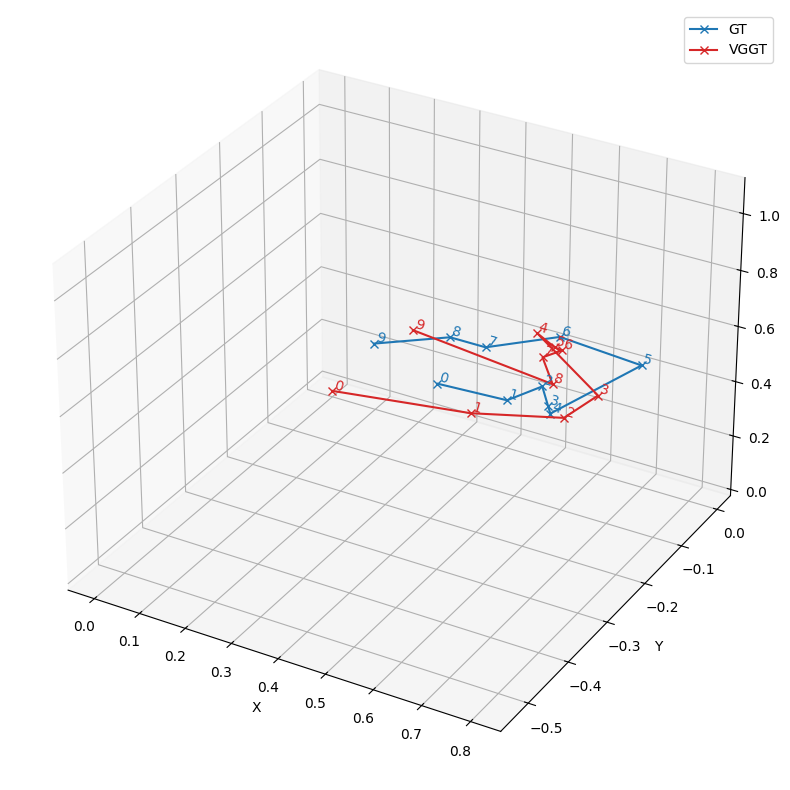

In [51]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assume 'farthest_comparision', 'farthest_extrinsic',
# 'vggt_farthest_extrinsic_cpu', and 'trajectory_similarity' are defined elsewhere

gt_centers = quant_comparision['A_centers']
vggt_centers = quant_comparision['B_centers']
gt_ext = quant_extrinsic.float()
vggt_ext_cpu = vggt_quant_extrinsic_cpu

# ======================================================

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# --- Plot GT trajectory and add index annotations ---
ax.plot(
    gt_centers[:,0], # X
    gt_centers[:,1], # Y
    gt_centers[:,2], # Z
    marker='x', linestyle='-', color='tab:blue', label='GT'
)
for i in range(len(gt_centers)):
    # Annotate each point (X, Y, Z, text_label)
    ax.text(
        gt_centers[i, 0],
        gt_centers[i, 1],
        gt_centers[i, 2],
        str(i), # The index number as text
        color='tab:blue',
        size=10,
        zdir='x' # Optional: helps with text orientation in 3D
    )

# --- Plot VGGT trajectory and add index annotations ---
ax.plot(
    vggt_centers[:,0], # X
    vggt_centers[:,1], # Y
    vggt_centers[:,2], # Z
    marker='x', linestyle='-', color='tab:red', label='VGGT'
)
for i in range(len(vggt_centers)):
    # Annotate each point (X, Y, Z, text_label)
    ax.text(
        vggt_centers[i, 0],
        vggt_centers[i, 1],
        vggt_centers[i, 2],
        str(i), # The index number as text
        color='tab:red',
        size=10,
        zdir='x' # Optional: helps with text orientation in 3D
    )

skip = trajectory_similarity(gt_ext, vggt_ext_cpu)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
ax.grid(True)
plt.show()